In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools

In [3]:
def EllisBaldwin(x, alpha, v=369.825*u.km/u.s):
    """
    Returns the expected dipole amplitude from Ellis & Baldwin (1984), given
        x = number-count slope at flux density limit
        alpha = source spectral index assuming power law spectra
    """
    return v / const.c.to(u.km/u.s) * (2 + x * (1+alpha))

#### load S21 CatWISE2020

In [4]:
cat_dir = '/scratch/aew492/quasars/catalogs'
S21_fn = os.path.join(cat_dir, f'Secrest/catwise_agns_masked_final_w1lt16p5_alpha.fits')
tab_S21 = Table.read(S21_fn, format='fits')

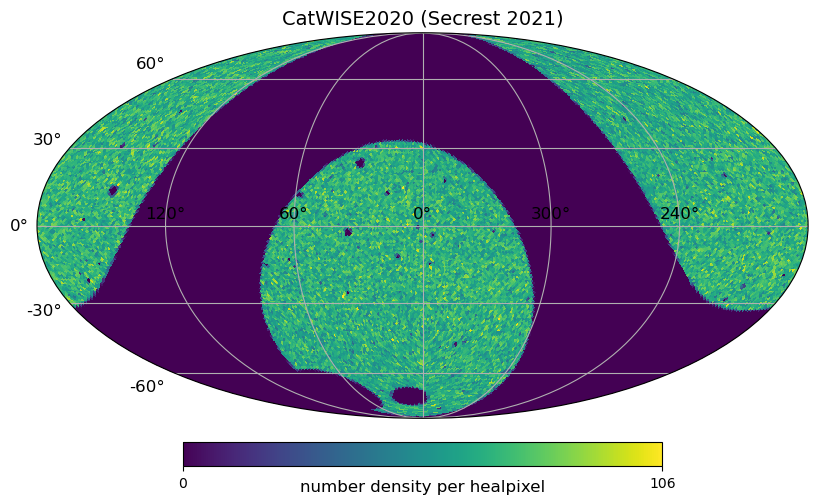

In [5]:
map_S21 = tools.load_catalog_as_map(S21_fn, frame='icrs')
tools.plot_map(map_S21, title='CatWISE2020 (Secrest 2021)', unit='number density per healpixel')

### spectral index $\alpha$ distribution

$$
\alpha = -\frac{d\log S_\nu}{d\log\nu}
$$

#### magnitudes $\mathrm{W}1-\mathrm{W}2$

WISE magnitudes are in the Vega system, so we need to convert to AB:

In [6]:
def Vega_to_AB(w1w2_Vega, offset=-0.640):  # offset computed from WISE photometric zero points
                            #  (Table 3 in https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html)
    return w1w2_Vega + offset

In [7]:
def compute_alpha(W1, W2, lambda_W1=3.3526, lambda_W2=4.6028):
    """
    Compute the spectral slope alpha for a source with given BP and RP magnitudes.
    PARAMETERS:
    - W1 = magnitude in W1 band (Vega system)
    - W2 = magnitude in W2 band (Vega system)
    - lambda_W1 = isophotal wavelength (microns) of W1 passband
    - lambda_R = isophotal wavelength (microns) of W2 passband
    """
    # convert given (W1-W2)_Vega to AB color (W1-W2)_AB
    W1W2_AB = Vega_to_AB(W1-W2)
    
    alpha = W1W2_AB/(2.5*np.log10(lambda_W2/lambda_W1))

    return alpha

Secrest makes a magnitude cut $9>\mathrm{W}1>16.4$ (Vega).

In [14]:
# magnitudes
mag_cut = (tab_S21['w1']<=16.4)
w1_ = tab_S21['w1'][mag_cut]
w2_ = tab_S21['w2'][mag_cut]

In [15]:
alphas = [compute_alpha(w1_[i], w2_[i]) for i in range(len(w1_))]

Text(0.5, 1.0, 'Quasar spectral slopes (S21 sample)')

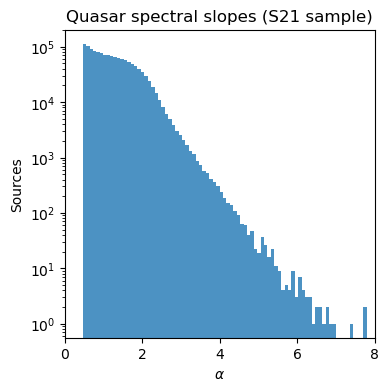

In [16]:
# plot distribution
fig, ax = plt.subplots(figsize=(4,4))

n, bins, _ = ax.hist(alphas, bins=120, alpha=0.8)
ax.set_xlim((0,8))  # to match plot in S21
ax.set_yscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Sources')
ax.set_title('Quasar spectral slopes (S21 sample)')

In [17]:
min(alphas), np.mean(alphas)

(0.46498067339046123, 1.2570238304804777)

According to S21 the mean is 1.26 !

I should note that I use the isophotal wavelengths published by WISE (Table 9) but S21 seems to calculate the isophotal wavelengths by hand (Eq. A19 in Bessel & Murphy 2012).

### number-count slope $x$

$$
x\equiv -\left.\frac{d\ln N(>S_\nu)}{d\ln S_\nu}\right|_{S_\mathrm{min}}
$$

We'll estimate the number-count slope at W1=16.4 as $(x_{16.5}-x_{16.3})0.2$

In [19]:
w1 = tab_S21['w1']

Text(0.5, 1.0, 'CatWISE2020 (Secrest sample)')

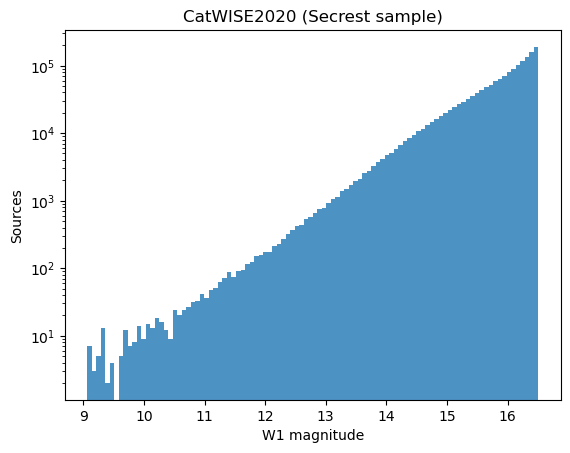

In [20]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(w1, bins=100, alpha=0.8)
ax.set_yscale('log')
ax.set_xlabel('W1 magnitude')
ax.set_ylabel('Sources')
ax.set_title('CatWISE2020 (Secrest sample)')

In [21]:
max(w1), np.sum(w1>16.4)/len(tab_S21)

(16.50094722830057, 0.15522391036604521)

In [22]:
# count the number of sources in bins of magnitude
width = 0.1
min_w1 = 14
max_w1 = 16.5
nmags = int((max_w1-min_w1)/width)+1
mags = np.linspace(min_w1, max_w1, nmags)
counts = np.array([np.sum(w1<=mag) for mag in mags])

Text(0.5, 1.0, 'CatWISE2020 W1 number counts')

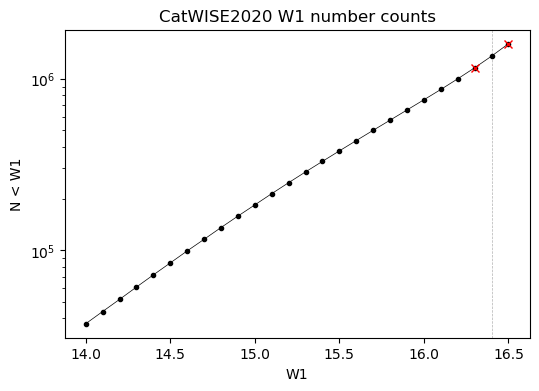

In [23]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(mags, counts, 'k.-', lw=0.5)
ax.axvline(16.4, color='k', alpha=0.3, ls='--', lw=0.5)
ax.plot(mags[-1], counts[-1], marker='x', color='r')
ax.plot(mags[-3], counts[-3], marker='x', color='r')

ax.set_yscale('log')
ax.set_xlabel('W1')
ax.set_ylabel('N < W1')
ax.set_title('CatWISE2020 W1 number counts')

In [24]:
# slope of interest:
dlogN = np.log10(counts[-1])-np.log10(counts[-3])
dmags = mags[-1]-mags[-3]
x = 2.5*(dlogN)/dmags
x

1.755116940618679

### expected dipole

In [25]:
EllisBaldwin(x, np.mean(alphas))

<Quantity 0.00735393>

### healpy fit

In [26]:
# prepare map
map_S21_tofit = np.copy(map_S21).astype(float)
map_S21_tofit[map_S21==0.] = hp.UNSEEN
map_nodip, monopole, dipole = hp.pixelfunc.remove_dipole(map_S21_tofit, fitval=True)

In [27]:
dipole/monopole

array([-0.01203086,  0.00780072,  0.00137645])

In [28]:
amp = np.linalg.norm(dipole/monopole)
direction = hp.vec2dir(dipole)
ra = direction[1]
dec = np.pi/2 - direction[0]
print(amp)
coord = SkyCoord(ra, dec, unit='rad', frame='icrs')
coord.galactic

0.014404421989149303


<SkyCoord (Galactic): (l, b) in deg
    (230.88440895, 41.37588042)>

S21 finds $\mathcal{D}=0.01554$ towards $(l,b)=(238.2^\circ,28.8^\circ)$